In [18]:
import flowermd
import gsd
import gsd.hoomd
import hoomd
import matplotlib.pyplot as plt
import mbuild as mb
import numpy as np
import warnings

from cmeutils.visualize import FresnelGSD
from flowermd.base import Pack, Simulation, System, Molecule
from flowermd.base.forcefield import BaseHOOMDForcefield
from flowermd.library import KremerGrestBeadSpring, LJChain
from flowermd.library.forcefields import BeadSpring
from flowermd.utils import get_target_box_number_density
from mbuild.compound import Compound
from mbuild.lattice import Lattice
warnings.filterwarnings('ignore')

class Graphene(System):
    def __init__(
        self,
        x_repeat,
        y_repeat,
        n_layers,
        base_units=dict(),
        periodicity=(True, True, False),
    ):
        surface = mb.Compound(periodicity=periodicity)
        scale = 1.0 # 1.0 for testing, 0.246 for graphene bond lengths
        spacings = [s * scale for s in [1.0, 1.0, 1.0]] # lattice spacing
        points = [[0, 0, 0], [2/3, 1/3, 0]] # unit cell points
        lattice = Lattice(
            lattice_spacing=spacings,
            angles=[90, 90, 120],
            lattice_points={"A": points},
        ) # angles between lattice vectors, 90-90-120 define a 2D hexagonal lattice extended into 3D.
        carbon = Compound(name="C", element="C") # defines a carbon atom that will be used to populate lattice points
        layers = lattice.populate(
            compound_dict={"A": carbon}, x=x_repeat, y=y_repeat, z=n_layers
        ) # populates the lattice using the previously defined carbon atom for every "A" site, repeated in all x,y, and z directions
        surface.add(layers) # adds populated carbon lattice layers to the 'surface' compound, which represents our graphene structure 
        surface.freud_generate_bonds("C", "C", dmin=0.3*scale, dmax=0.6*scale) # generates bonds depending on input distance range, scales with lattice
        surface_mol = Molecule(num_mols=1, compound=surface) # wraps into a Molecule object, creating "1" instance of this molecule

        super(Graphene, self).__init__(
            molecules=[surface_mol],
            base_units=base_units,
        )

    def _build_system(self):
        return self.all_molecules[0]
#OK, so we want to initialize a system with some chains and some flakes
kg_chain = LJChain(lengths=2,num_mols=1)
sheet = Graphene(x_repeat=2, y_repeat=2, n_layers=1, periodicity=(False, False, False))
system = Pack(molecules=[Molecule(compound=sheet.all_molecules[0], num_mols=1), kg_chain], density=0.01, packing_expand_factor = 5, seed=5)
system.visualize()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
# this FF is for research question
ff = BeadSpring(
    r_cut=2.5,  
    beads={
        "A": dict(epsilon=1.0, sigma=1.0),  # chains
        "C": dict(epsilon=1.0, sigma=1.0),  # flakes
    },
    bonds={
        "C-C": dict(r0=1.0, k=10),
        "A-A": dict(r0=1.0, k=10.0),  # increased k to avoid chain collapse
    },
    angles={
        "A-A-A": dict(t0=2*np.pi/3, k=10.0),   # moderate stiffness for chains
        "C-C-C": dict(t0=2 * np.pi / 3., k=500),
    },
    dihedrals={
        "A-A-A-A": dict(phi0=0.0, k=1.0, d=-1, n=1),
        "C-C-C-C": dict(phi0=0.0, k=500, d=-1, n=1),
    }
)

Initializing simulation state from a gsd.hoomd.Frame.
Step 1000 of 20000; TPS: 8539.78; ETA: 0.0 minutes
Step 2000 of 20000; TPS: 16852.47; ETA: 0.0 minutes
Step 3000 of 20000; TPS: 24966.09; ETA: 0.0 minutes
Step 4000 of 20000; TPS: 32882.57; ETA: 0.0 minutes
Step 5000 of 20000; TPS: 40538.68; ETA: 0.0 minutes
Step 6000 of 20000; TPS: 48026.9; ETA: 0.0 minutes
Step 7000 of 20000; TPS: 55282.22; ETA: 0.0 minutes
Step 8000 of 20000; TPS: 62413.69; ETA: 0.0 minutes
Step 9000 of 20000; TPS: 69397.32; ETA: 0.0 minutes
Step 10000 of 20000; TPS: 76226.48; ETA: 0.0 minutes
Step 11000 of 20000; TPS: 82813.86; ETA: 0.0 minutes
Step 12000 of 20000; TPS: 89268.45; ETA: 0.0 minutes
Step 13000 of 20000; TPS: 95630.43; ETA: 0.0 minutes
Step 14000 of 20000; TPS: 101866.34; ETA: 0.0 minutes
Step 15000 of 20000; TPS: 107971.15; ETA: 0.0 minutes
Step 16000 of 20000; TPS: 113870.9; ETA: 0.0 minutes
Step 17000 of 20000; TPS: 119607.97; ETA: 0.0 minutes
Step 18000 of 20000; TPS: 125313.28; ETA: 0.0 minutes

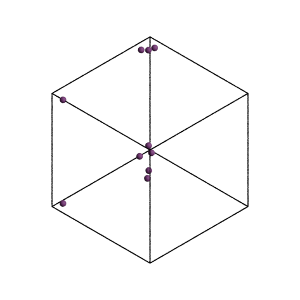

In [32]:
cpu = hoomd.device.CPU()
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device=cpu, dt = 0.0001, gsd_write_freq=int(1000), log_file_name = "ej_flakes.txt")
sim.run_NVT(n_steps=20000, kT=1., tau_kt=.1)
sim.flush_writers()
sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=-1, view_axis=(1, 1, 1))
sim_visualizer.view()